In [1]:
import glog
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import sys
import torch.nn.functional as F


sys.path.append('../..')
import xfinai_config
from data_layer.base_dataset import FuturesDatasetTable
from utils import path_wrapper, plotter

### 0 Loading Data

In [2]:
future_index= 'ic'
params = {
    "batch_size": 32,
    "hidden_size": 64,
    "seq_length": 8,
    "weight_decay": 0.03699014272607559,
    "num_layers": 8,
    "learning_rate": 0.1264079267383521,
    "dropout_prob": 0.0049846528896436
}

In [3]:
# Load data
train_data = pd.read_pickle(f"{xfinai_config.featured_data_path}/{future_index}_train_data.pkl")
val_data = pd.read_pickle(f"{xfinai_config.featured_data_path}/{future_index}_val_data.pkl")
test_data = pd.read_pickle(f"{xfinai_config.featured_data_path}/{future_index}_test_data.pkl")

### 1 Define LSTM Model

In [28]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size, device):
        super().__init__()
        self.name = 'MLP'
        self.device = device

        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x.squeeze(1)

In [33]:
def eval_model(model, dataloader, data_set_name, future_name, params):
    with torch.no_grad():
        y_real_list = np.array([])
        y_pred_list = np.array([])

        for idx, (x_batch, y_batch) in enumerate(dataloader):
            # Convert to Tensors
            x_batch = x_batch.float().to(model.device)
            y_batch = y_batch.float().to(model.device)

            y_pred = model(x_batch)

            y_real_list = np.append(y_real_list, y_batch.cpu().numpy())
            y_pred_list = np.append(y_pred_list, y_pred.cpu().numpy())

    plt.figure(figsize=[15, 3], dpi=100)
    plt.plot(y_real_list, label=f'{data_set_name}_real')
    plt.plot(y_pred_list, label=f'{data_set_name}_pred')
    plt.legend()
    plt.title(f"Inference On {data_set_name} Set - {model.name} {future_name}")
    plt.xlabel('Time')
    plt.ylabel('Return')
    plt.subplots_adjust(bottom=0.15)

    result_dir = path_wrapper.wrap_path(f"{xfinai_config.inference_result_path}/{future_name}/{model.name}")
    plt.savefig(f"{result_dir}/{data_set_name}.png")
    

def save_model(model, future_name):
    dir_path = path_wrapper.wrap_path(f"{xfinai_config.model_save_path}/{future_name}")
    save_path = f"{dir_path}/{model.name}.pth"
    glog.info(f"Starting save model state, save_path: {save_path}")
    torch.save(model.state_dict(), save_path)

### 2 Create Training Func

In [19]:
def train(train_data_loader, model, criterion, optimizer, params):
    glog.info(f"Start Training Model")

    # Set to train mode
    model.train()
    running_train_loss = 0.0

    # Begin training
    for idx, (x_batch, y_batch) in enumerate(train_data_loader):
        optimizer.zero_grad()

        # Convert to Tensors
        x_batch = x_batch.float().to(model.device)
        y_batch = y_batch.float().to(model.device)

        # Make prediction
        y_pred = model(x_batch)

        # Calculate loss
        loss = criterion(y_pred, y_batch)
        loss.backward()
        running_train_loss += loss.item()

        optimizer.step()

    glog.info(f"End Training Model")

    train_loss_average = running_train_loss / len(train_data_loader)
    return model, train_loss_average

In [24]:
def validate(val_data_loader, model, criterion, params):
    # Set to eval mode
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():

        for idx, (x_batch, y_batch) in enumerate(val_data_loader):
            # Convert to Tensors
            x_batch = x_batch.float().to(model.device)
            y_batch = y_batch.float().to(model.device)

            y_pred = model(x_batch)
            
            val_loss = criterion(y_pred, y_batch)
            running_val_loss += val_loss.item()

    val_loss_average = running_val_loss / len(val_data_loader)
    return val_loss_average

### 3 Run Training

In [8]:
# Transfer to accelerator
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Create dataset & data loader
train_dataset = FuturesDatasetTable(data=train_data, label=xfinai_config.label)
val_dataset = FuturesDatasetTable(data=train_data, label=xfinai_config.label)
test_dataset = FuturesDatasetTable(data=test_data, label=xfinai_config.label)
train_loader = DataLoader(dataset=train_dataset, **xfinai_config.data_loader_config,
                          batch_size=params['batch_size'])
val_loader = DataLoader(dataset=val_dataset, **xfinai_config.data_loader_config,
                        batch_size=params['batch_size'])
test_loader = DataLoader(dataset=test_dataset, **xfinai_config.data_loader_config,
                         batch_size=params['batch_size'])

In [29]:

# create model instance
model = MLP(
    input_size=len(train_dataset.features_list),
    output_size=xfinai_config.lstm_model_config['output_size'],
    device=device
).to(device)

criterion = nn.MSELoss()

optimizer = optim.AdamW(model.parameters(),
                        lr=params['learning_rate'],
                        weight_decay=params['weight_decay'])

epochs = 100

print(model)
train_losses = []
val_losses = []
# train the model
for epoch in range(epochs):
    trained_model, train_score = train(train_data_loader=train_loader, model=model, criterion=criterion,
                                       optimizer=optimizer,
                                       params=params)
    val_score = validate(val_data_loader=val_loader, model=trained_model, criterion=criterion, params=params)

    # report intermediate result
    print(f"Epoch :{epoch} train_score {train_score} val_score {val_score}")
    train_losses.append(train_score)
    val_losses.append(val_score)

I0313 12:07:05.793999 21512 2101436429.py:2] Start Training Model


MLP(
  (fc1): Linear(in_features=24, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)


I0313 12:07:08.468616 21512 2101436429.py:26] End Training Model
I0313 12:07:10.793584 21512 2101436429.py:2] Start Training Model


Epoch :0 train_score 12847507.85625 val_score 8182441.654166667


I0313 12:07:13.423067 21512 2101436429.py:26] End Training Model
I0313 12:07:15.742337 21512 2101436429.py:2] Start Training Model


Epoch :1 train_score 16650285.29360119 val_score 11986720.122172618


I0313 12:07:18.405102 21512 2101436429.py:26] End Training Model
I0313 12:07:20.705141 21512 2101436429.py:2] Start Training Model


Epoch :2 train_score 10622012.750595238 val_score 9156570.789583333


I0313 12:07:23.344165 21512 2101436429.py:26] End Training Model
I0313 12:07:25.684263 21512 2101436429.py:2] Start Training Model


Epoch :3 train_score 13077647.099851191 val_score 10744833.741145832


I0313 12:07:28.319819 21512 2101436429.py:26] End Training Model
I0313 12:07:30.659372 21512 2101436429.py:2] Start Training Model


Epoch :4 train_score 11607986.108779762 val_score 15333125.42299107


I0313 12:07:33.292547 21512 2101436429.py:26] End Training Model
I0313 12:07:35.592408 21512 2101436429.py:2] Start Training Model


Epoch :5 train_score 10664322.558928572 val_score 7229162.18266369


I0313 12:07:38.244519 21512 2101436429.py:26] End Training Model
I0313 12:07:40.604410 21512 2101436429.py:2] Start Training Model


Epoch :6 train_score 9077747.854017857 val_score 6770631.035453869


I0313 12:07:43.250360 21512 2101436429.py:26] End Training Model
I0313 12:07:45.580426 21512 2101436429.py:2] Start Training Model


Epoch :7 train_score 6494254.384895833 val_score 5376602.1727306545


I0313 12:07:48.265721 21512 2101436429.py:26] End Training Model
I0313 12:07:50.586325 21512 2101436429.py:2] Start Training Model


Epoch :8 train_score 6647364.367931548 val_score 3992725.3691220237


I0313 12:07:53.236758 21512 2101436429.py:26] End Training Model
I0313 12:07:55.546303 21512 2101436429.py:2] Start Training Model


Epoch :9 train_score 4513094.5750744045 val_score 3113918.3200892857


I0313 12:07:58.183871 21512 2101436429.py:26] End Training Model
I0313 12:08:00.500331 21512 2101436429.py:2] Start Training Model


Epoch :10 train_score 3834797.860453869 val_score 3888249.808407738


I0313 12:08:03.156839 21512 2101436429.py:26] End Training Model
I0313 12:08:05.484375 21512 2101436429.py:2] Start Training Model


Epoch :11 train_score 2962591.8936011903 val_score 2564405.128236607


I0313 12:08:08.158584 21512 2101436429.py:26] End Training Model
I0313 12:08:10.442267 21512 2101436429.py:2] Start Training Model


Epoch :12 train_score 3514790.4827566966 val_score 11935793.453720238


I0313 12:08:13.074747 21512 2101436429.py:26] End Training Model
I0313 12:08:15.398022 21512 2101436429.py:2] Start Training Model


Epoch :13 train_score 9384224.001339287 val_score 11843246.95654762


I0313 12:08:18.093451 21512 2101436429.py:26] End Training Model
I0313 12:08:20.414856 21512 2101436429.py:2] Start Training Model


Epoch :14 train_score 5717948.723883929 val_score 3780385.3270833334


I0313 12:08:23.060163 21512 2101436429.py:26] End Training Model
I0313 12:08:25.355933 21512 2101436429.py:2] Start Training Model


Epoch :15 train_score 5256930.6063244045 val_score 6450178.428422619


I0313 12:08:28.008049 21512 2101436429.py:26] End Training Model
I0313 12:08:30.338112 21512 2101436429.py:2] Start Training Model


Epoch :16 train_score 4619314.933184524 val_score 3497491.372172619


I0313 12:08:32.980987 21512 2101436429.py:26] End Training Model
I0313 12:08:35.300170 21512 2101436429.py:2] Start Training Model


Epoch :17 train_score 3476873.3823660715 val_score 5364241.084821428


I0313 12:08:37.952547 21512 2101436429.py:26] End Training Model
I0313 12:08:40.276580 21512 2101436429.py:2] Start Training Model


Epoch :18 train_score 3759418.119903274 val_score 6859885.513988095


I0313 12:08:42.922493 21512 2101436429.py:26] End Training Model
I0313 12:08:45.239121 21512 2101436429.py:2] Start Training Model


Epoch :19 train_score 6056211.060193452 val_score 4534435.570684524


I0313 12:08:47.867261 21512 2101436429.py:26] End Training Model
I0313 12:08:50.200533 21512 2101436429.py:2] Start Training Model


Epoch :20 train_score 4349878.826116071 val_score 8180995.152715774


I0313 12:08:52.823839 21512 2101436429.py:26] End Training Model
I0313 12:08:55.116313 21512 2101436429.py:2] Start Training Model


Epoch :21 train_score 5659188.907589286 val_score 13368555.835714286


I0313 12:08:57.782115 21512 2101436429.py:26] End Training Model
I0313 12:09:00.125658 21512 2101436429.py:2] Start Training Model


Epoch :22 train_score 4218217.633110119 val_score 8830082.892559525


I0313 12:09:02.874765 21512 2101436429.py:26] End Training Model
I0313 12:09:05.264994 21512 2101436429.py:2] Start Training Model


Epoch :23 train_score 16051620.701488094 val_score 11404392.044791667


I0313 12:09:07.936726 21512 2101436429.py:26] End Training Model
I0313 12:09:10.259966 21512 2101436429.py:2] Start Training Model


Epoch :24 train_score 6481061.574404762 val_score 4913577.2863095235


I0313 12:09:12.897362 21512 2101436429.py:26] End Training Model
I0313 12:09:15.220534 21512 2101436429.py:2] Start Training Model


Epoch :25 train_score 7789225.032291667 val_score 5947570.433630953


I0313 12:09:17.861434 21512 2101436429.py:26] End Training Model
I0313 12:09:20.154994 21512 2101436429.py:2] Start Training Model


Epoch :26 train_score 7613215.449330357 val_score 5193794.411607143


I0313 12:09:22.819877 21512 2101436429.py:26] End Training Model
I0313 12:09:25.121302 21512 2101436429.py:2] Start Training Model


Epoch :27 train_score 8316621.674702381 val_score 6613516.075595238


I0313 12:09:27.776179 21512 2101436429.py:26] End Training Model
I0313 12:09:30.080229 21512 2101436429.py:2] Start Training Model


Epoch :28 train_score 5497911.803273809 val_score 3900519.5858630952


I0313 12:09:32.702309 21512 2101436429.py:26] End Training Model
I0313 12:09:35.002621 21512 2101436429.py:2] Start Training Model


Epoch :29 train_score 4072281.4058035715 val_score 4648985.884895833


I0313 12:09:37.640858 21512 2101436429.py:26] End Training Model
I0313 12:09:39.974791 21512 2101436429.py:2] Start Training Model


Epoch :30 train_score 3360312.212425595 val_score 2968822.5773065477


I0313 12:09:42.630425 21512 2101436429.py:26] End Training Model
I0313 12:09:44.953216 21512 2101436429.py:2] Start Training Model


Epoch :31 train_score 4502580.905282738 val_score 5465736.88452381


I0313 12:09:47.635607 21512 2101436429.py:26] End Training Model
I0313 12:09:49.969023 21512 2101436429.py:2] Start Training Model


Epoch :32 train_score 3750457.929389881 val_score 10748341.72061012


I0313 12:09:52.624904 21512 2101436429.py:26] End Training Model
I0313 12:09:54.925784 21512 2101436429.py:2] Start Training Model


Epoch :33 train_score 18339627.567261904 val_score 23897020.07202381


I0313 12:09:57.590572 21512 2101436429.py:26] End Training Model
I0313 12:09:59.906972 21512 2101436429.py:2] Start Training Model


Epoch :34 train_score 26328844.794940475 val_score 39423282.104761906


I0313 12:10:02.546960 21512 2101436429.py:26] End Training Model
I0313 12:10:04.866807 21512 2101436429.py:2] Start Training Model


Epoch :35 train_score 11344483.910453869 val_score 10605938.21421131


I0313 12:10:07.555071 21512 2101436429.py:26] End Training Model
I0313 12:10:09.865968 21512 2101436429.py:2] Start Training Model


Epoch :36 train_score 12641195.774702381 val_score 10262307.29341518


I0313 12:10:12.511981 21512 2101436429.py:26] End Training Model
I0313 12:10:14.883359 21512 2101436429.py:2] Start Training Model


Epoch :37 train_score 16352923.710863095 val_score 19515347.187946428


I0313 12:10:17.539846 21512 2101436429.py:26] End Training Model
I0313 12:10:19.853377 21512 2101436429.py:2] Start Training Model


Epoch :38 train_score 17701459.50029762 val_score 7635842.530580357


I0313 12:10:22.460211 21512 2101436429.py:26] End Training Model
I0313 12:10:24.768936 21512 2101436429.py:2] Start Training Model


Epoch :39 train_score 7370976.247581845 val_score 4672971.565699405


I0313 12:10:27.481159 21512 2101436429.py:26] End Training Model
I0313 12:10:29.794617 21512 2101436429.py:2] Start Training Model


Epoch :40 train_score 5560070.563764881 val_score 3057957.9009672618


I0313 12:10:32.420994 21512 2101436429.py:26] End Training Model
I0313 12:10:34.733091 21512 2101436429.py:2] Start Training Model


Epoch :41 train_score 3648933.1451636907 val_score 2873552.773809524


I0313 12:10:37.439343 21512 2101436429.py:26] End Training Model
I0313 12:10:39.749050 21512 2101436429.py:2] Start Training Model


Epoch :42 train_score 3790302.935379464 val_score 3195352.4793526786


I0313 12:10:42.409387 21512 2101436429.py:26] End Training Model
I0313 12:10:44.733054 21512 2101436429.py:2] Start Training Model


Epoch :43 train_score 3907506.076078869 val_score 3317805.7457589284


I0313 12:10:47.383761 21512 2101436429.py:26] End Training Model
I0313 12:10:49.707978 21512 2101436429.py:2] Start Training Model


Epoch :44 train_score 3802191.71171875 val_score 3493224.2116815476


I0313 12:10:52.331837 21512 2101436429.py:26] End Training Model
I0313 12:10:54.619925 21512 2101436429.py:2] Start Training Model


Epoch :45 train_score 3247953.6928385417 val_score 3142754.034895833


I0313 12:10:57.327716 21512 2101436429.py:26] End Training Model
I0313 12:10:59.633684 21512 2101436429.py:2] Start Training Model


Epoch :46 train_score 2826291.7682291665 val_score 5910530.219345238


I0313 12:11:02.268356 21512 2101436429.py:26] End Training Model
I0313 12:11:04.608877 21512 2101436429.py:2] Start Training Model


Epoch :47 train_score 3807333.055877976 val_score 5412888.322321429


I0313 12:11:07.317245 21512 2101436429.py:26] End Training Model
I0313 12:11:10.223353 21512 2101436429.py:2] Start Training Model


Epoch :48 train_score 3855956.384375 val_score 6969935.720907738


I0313 12:11:13.587222 21512 2101436429.py:26] End Training Model
I0313 12:11:18.254275 21512 2101436429.py:2] Start Training Model


Epoch :49 train_score 2622362.155059524 val_score 6248988.90703125


I0313 12:11:21.154911 21512 2101436429.py:26] End Training Model
I0313 12:11:23.694166 21512 2101436429.py:2] Start Training Model


Epoch :50 train_score 4747738.430282738 val_score 3380893.6873511905


I0313 12:11:26.604774 21512 2101436429.py:26] End Training Model
I0313 12:11:29.012817 21512 2101436429.py:2] Start Training Model


Epoch :51 train_score 4134833.1754464284 val_score 5527561.921651785


I0313 12:11:31.722994 21512 2101436429.py:26] End Training Model
I0313 12:11:34.279627 21512 2101436429.py:2] Start Training Model


Epoch :52 train_score 5912945.763095238 val_score 8912704.173809525


I0313 12:11:37.093839 21512 2101436429.py:26] End Training Model
I0313 12:11:39.527325 21512 2101436429.py:2] Start Training Model


Epoch :53 train_score 5494271.109077381 val_score 6223528.095498512


I0313 12:11:42.187062 21512 2101436429.py:26] End Training Model
I0313 12:11:44.514016 21512 2101436429.py:2] Start Training Model


Epoch :54 train_score 9852056.641220238 val_score 9146481.830654763


I0313 12:11:47.189066 21512 2101436429.py:26] End Training Model
I0313 12:11:49.512163 21512 2101436429.py:2] Start Training Model


Epoch :55 train_score 11449451.813690476 val_score 8697066.993898809


I0313 12:11:52.144941 21512 2101436429.py:26] End Training Model
I0313 12:11:54.451812 21512 2101436429.py:2] Start Training Model


Epoch :56 train_score 4370810.124479166 val_score 3696389.4368675593


I0313 12:11:57.128458 21512 2101436429.py:26] End Training Model
I0313 12:11:59.436964 21512 2101436429.py:2] Start Training Model


Epoch :57 train_score 7143908.135305059 val_score 5900467.280543155


I0313 12:12:02.071454 21512 2101436429.py:26] End Training Model
I0313 12:12:04.376609 21512 2101436429.py:2] Start Training Model


Epoch :58 train_score 12633445.034449404 val_score 14832750.468005951


I0313 12:12:06.994791 21512 2101436429.py:26] End Training Model
I0313 12:12:09.311596 21512 2101436429.py:2] Start Training Model


Epoch :59 train_score 28200612.08467262 val_score 48921609.37142857


I0313 12:12:11.957569 21512 2101436429.py:26] End Training Model
I0313 12:12:14.414349 21512 2101436429.py:2] Start Training Model


Epoch :60 train_score 48724039.98095238 val_score 48563845.56190476


I0313 12:12:17.050374 21512 2101436429.py:26] End Training Model
I0313 12:12:19.386329 21512 2101436429.py:2] Start Training Model


Epoch :61 train_score 48526693.84761905 val_score 48514214.190476194


I0313 12:12:22.047061 21512 2101436429.py:26] End Training Model
I0313 12:12:24.362923 21512 2101436429.py:2] Start Training Model


Epoch :62 train_score 48526181.6952381 val_score 48542639.84761905


I0313 12:12:27.009012 21512 2101436429.py:26] End Training Model
I0313 12:12:29.341052 21512 2101436429.py:2] Start Training Model


Epoch :63 train_score 45171254.31071428 val_score 48973322.20952381


I0313 12:12:32.007278 21512 2101436429.py:26] End Training Model
I0313 12:12:34.341188 21512 2101436429.py:2] Start Training Model


Epoch :64 train_score 31023876.56889881 val_score 23382814.997581847


I0313 12:12:37.010494 21512 2101436429.py:26] End Training Model
I0313 12:12:39.326462 21512 2101436429.py:2] Start Training Model


Epoch :65 train_score 14204713.153720237 val_score 15296765.961235119


I0313 12:12:41.971903 21512 2101436429.py:26] End Training Model
I0313 12:12:44.283117 21512 2101436429.py:2] Start Training Model


Epoch :66 train_score 7819694.846875 val_score 12088360.753050596


I0313 12:12:46.934381 21512 2101436429.py:26] End Training Model
I0313 12:12:49.280538 21512 2101436429.py:2] Start Training Model


Epoch :67 train_score 24998318.05565476 val_score 49046130.0


I0313 12:12:51.946715 21512 2101436429.py:26] End Training Model
I0313 12:12:54.286664 21512 2101436429.py:2] Start Training Model


Epoch :68 train_score 49000486.55238095 val_score 48861370.60952381


I0313 12:12:56.918975 21512 2101436429.py:26] End Training Model
I0313 12:12:59.225215 21512 2101436429.py:2] Start Training Model


Epoch :69 train_score 48731749.6 val_score 48653036.8


I0313 12:13:01.919418 21512 2101436429.py:26] End Training Model
I0313 12:13:04.210891 21512 2101436429.py:2] Start Training Model


Epoch :70 train_score 48626248.28571428 val_score 48612494.15238095


I0313 12:13:06.859330 21512 2101436429.py:26] End Training Model
I0313 12:13:09.179694 21512 2101436429.py:2] Start Training Model


Epoch :71 train_score 48613696.952380955 val_score 48618288.70476191


I0313 12:13:11.826205 21512 2101436429.py:26] End Training Model
I0313 12:13:14.156239 21512 2101436429.py:2] Start Training Model


Epoch :72 train_score 48626247.657142855 val_score 48634597.23809524


I0313 12:13:16.791757 21512 2101436429.py:26] End Training Model
I0313 12:13:19.104494 21512 2101436429.py:2] Start Training Model


Epoch :73 train_score 28313853.200520832 val_score 11358446.745238096


I0313 12:13:21.761077 21512 2101436429.py:26] End Training Model
I0313 12:13:24.084101 21512 2101436429.py:2] Start Training Model


Epoch :74 train_score 27155293.73236607 val_score 49033696.85714286


I0313 12:13:26.750741 21512 2101436429.py:26] End Training Model
I0313 12:13:29.069273 21512 2101436429.py:2] Start Training Model


Epoch :75 train_score 49025735.657142855 val_score 48981178.62857143


I0313 12:13:31.746173 21512 2101436429.py:26] End Training Model
I0313 12:13:34.048752 21512 2101436429.py:2] Start Training Model


Epoch :76 train_score 48817041.46666667 val_score 48728283.276190475


I0313 12:13:36.692278 21512 2101436429.py:26] End Training Model
I0313 12:13:39.033961 21512 2101436429.py:2] Start Training Model


Epoch :77 train_score 48691860.057142854 val_score 48668497.733333334


I0313 12:13:41.688387 21512 2101436429.py:26] End Training Model
I0313 12:13:43.996408 21512 2101436429.py:2] Start Training Model


Epoch :78 train_score 48661361.352380954 val_score 48658361.18095238


I0313 12:13:46.635536 21512 2101436429.py:26] End Training Model
I0313 12:13:48.978801 21512 2101436429.py:2] Start Training Model


Epoch :79 train_score 48660315.86666667 val_score 48663320.17142857


I0313 12:13:51.632538 21512 2101436429.py:26] End Training Model
I0313 12:13:54.015221 21512 2101436429.py:2] Start Training Model


Epoch :80 train_score 48667477.2 val_score 48671665.733333334


I0313 12:13:56.668478 21512 2101436429.py:26] End Training Model
I0313 12:13:59.003379 21512 2101436429.py:2] Start Training Model


Epoch :81 train_score 48675817.48571429 val_score 48679704.78095238


I0313 12:14:01.660212 21512 2101436429.py:26] End Training Model
I0313 12:14:04.000371 21512 2101436429.py:2] Start Training Model


Epoch :82 train_score 48683263.25714286 val_score 48686504.8


I0313 12:14:06.671909 21512 2101436429.py:26] End Training Model
I0313 12:14:08.998008 21512 2101436429.py:2] Start Training Model


Epoch :83 train_score 48689399.56190476 val_score 48691997.047619045


I0313 12:14:11.650952 21512 2101436429.py:26] End Training Model
I0313 12:14:13.968436 21512 2101436429.py:2] Start Training Model


Epoch :84 train_score 48694316.70476191 val_score 48696371.84761905


I0313 12:14:16.584217 21512 2101436429.py:26] End Training Model
I0313 12:14:18.902849 21512 2101436429.py:2] Start Training Model


Epoch :85 train_score 48698223.123809524 val_score 48699840.43809524


I0313 12:14:21.553273 21512 2101436429.py:26] End Training Model
I0313 12:14:23.882367 21512 2101436429.py:2] Start Training Model


Epoch :86 train_score 48701323.75238095 val_score 48702593.809523806


I0313 12:14:26.529140 21512 2101436429.py:26] End Training Model
I0313 12:14:28.857546 21512 2101436429.py:2] Start Training Model


Epoch :87 train_score 48703789.6952381 val_score 48704794.85714286


I0313 12:14:31.520807 21512 2101436429.py:26] End Training Model
I0313 12:14:33.840833 21512 2101436429.py:2] Start Training Model


Epoch :88 train_score 48705756.53333333 val_score 48706546.4


I0313 12:14:36.519837 21512 2101436429.py:26] End Training Model
I0313 12:14:38.862224 21512 2101436429.py:2] Start Training Model


Epoch :89 train_score 48707329.39047619 val_score 48707950.266666666


I0313 12:14:41.509634 21512 2101436429.py:26] End Training Model
I0313 12:14:43.818278 21512 2101436429.py:2] Start Training Model


Epoch :90 train_score 48708591.23809524 val_score 48709082.038095236


I0313 12:14:46.468469 21512 2101436429.py:26] End Training Model
I0313 12:14:48.807014 21512 2101436429.py:2] Start Training Model


Epoch :91 train_score 48709604.83809524 val_score 48709987.942857146


I0313 12:14:51.456939 21512 2101436429.py:26] End Training Model
I0313 12:14:53.787247 21512 2101436429.py:2] Start Training Model


Epoch :92 train_score 48710421.25714286 val_score 48710717.276190475


I0313 12:14:56.449044 21512 2101436429.py:26] End Training Model
I0313 12:14:58.751670 21512 2101436429.py:2] Start Training Model


Epoch :93 train_score 48711078.81904762 val_score 48711303.54285714


I0313 12:15:01.389474 21512 2101436429.py:26] End Training Model
I0313 12:15:03.708412 21512 2101436429.py:2] Start Training Model


Epoch :94 train_score 48711610.0 val_score 48711780.647619046


I0313 12:15:06.350173 21512 2101436429.py:26] End Training Model
I0313 12:15:08.696438 21512 2101436429.py:2] Start Training Model


Epoch :95 train_score 48712039.52380952 val_score 48712169.25714286


I0313 12:15:11.357659 21512 2101436429.py:26] End Training Model
I0313 12:15:13.684114 21512 2101436429.py:2] Start Training Model


Epoch :96 train_score 48712386.647619046 val_score 48712482.62857143


I0313 12:15:16.319407 21512 2101436429.py:26] End Training Model
I0313 12:15:18.671033 21512 2101436429.py:2] Start Training Model


Epoch :97 train_score 48712667.52380952 val_score 48712734.76190476


I0313 12:15:21.418767 21512 2101436429.py:26] End Training Model
I0313 12:15:23.767911 21512 2101436429.py:2] Start Training Model


Epoch :98 train_score 48712894.876190476 val_score 48712936.876190476


I0313 12:15:26.418131 21512 2101436429.py:26] End Training Model


Epoch :99 train_score 48713078.83809524 val_score 48713102.876190476


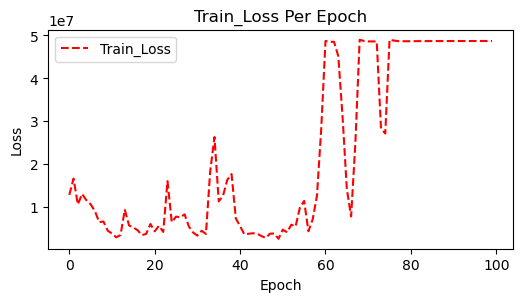

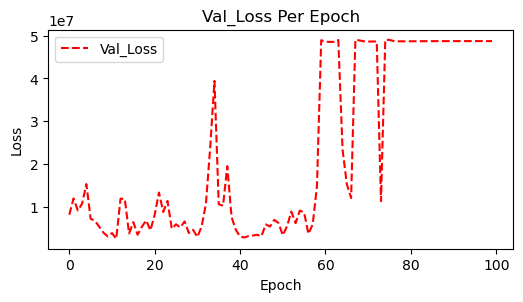

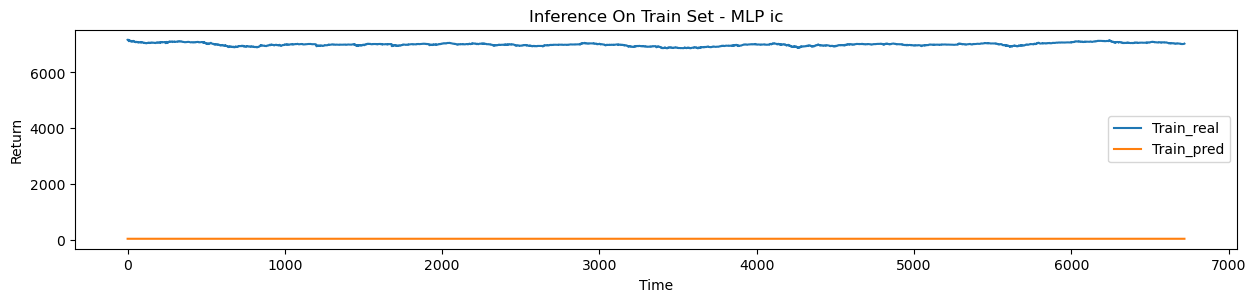

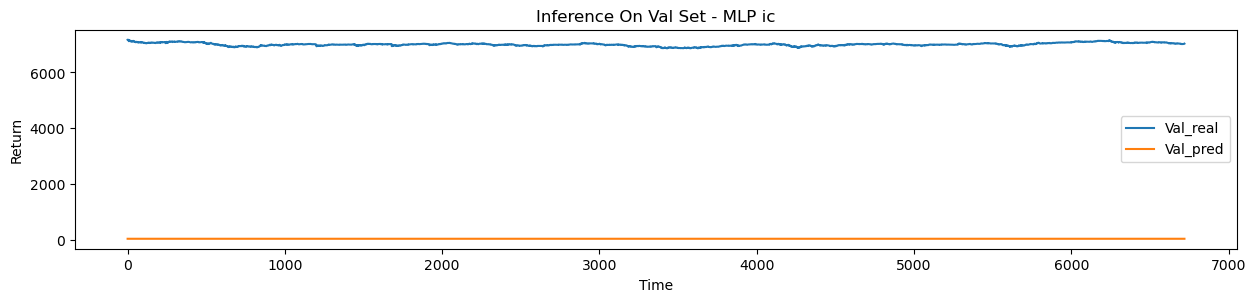

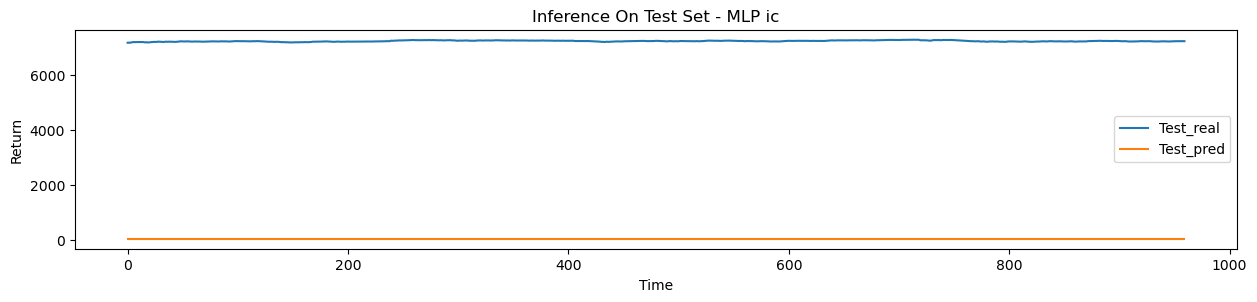

In [34]:
# # save the model
# save_model(trained_model, future_index)

# plot losses
plotter.plot_loss(train_losses, epochs, 'Train_Loss', trained_model.name, future_index)
plotter.plot_loss(val_losses, epochs, 'Val_Loss', trained_model.name, future_index)

# eval model on 3 datasets
for dataloader, data_set_name in zip([train_loader, val_loader, test_loader],
                                     ['Train', 'Val', 'Test']):
    eval_model(model=trained_model, dataloader=dataloader, data_set_name=data_set_name,
               future_name=future_index, params=params)